Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

### Importing Skin Cancer Data


In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [4]:
#Using kaggle for this case study so that the GPU power can be leveraged and as Google colab has lot of issues while performing this case study
#as it signs out automatically after a time period if there is no user interaction.
#Hence, input directory of kaggle is used for uploading the dataset and the output folder is used to store the images which are generated
# while avoiding class imbalancing at a later stage during model 3 building.
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed=123,
    validation_split=0.2,
    subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

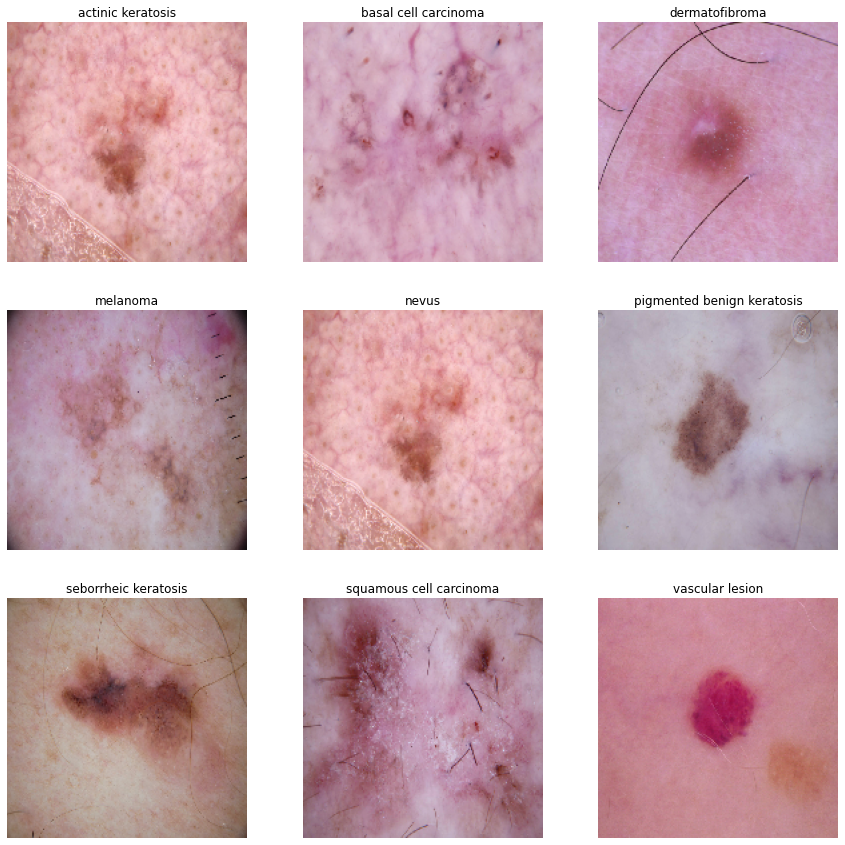

In [10]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [11]:
#Visualize distribution of classes in the training dataset.

def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,squamous cell carcinoma,181
1,nevus,357
2,basal cell carcinoma,376
3,melanoma,438
4,vascular lesion,139
5,actinic keratosis,114
6,dermatofibroma,95
7,seborrheic keratosis,77
8,pigmented benign keratosis,462


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

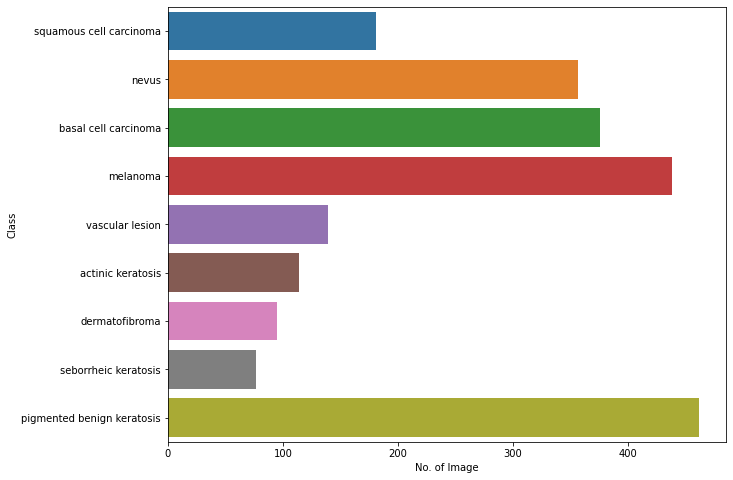

In [12]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

# Model M1

In [14]:
## Number of classes is 9
num_class = 9
input_shape = (img_height,img_width,3)

model = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(32,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(64,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(128,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Flatten(),
    
    layers.Dense(512,activation='relu'),
    layers.Dense(num_class,activation='softmax')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [17]:
epochs = 20
history = model.fit(
    train_ds,
    verbose=1,
    batch_size=batch_size,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 97ms/step - loss: 2.1245 - accuracy: 0.2946 - val_loss: 1.8000 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5703 - accuracy: 0.4269 - val_loss: 1.4522 - val_accuracy: 0.4966
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4325 - accuracy: 0.4933 - val_loss: 1.3599 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3295 - accuracy: 0.5285 - val_loss: 1.3813 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.2236 - accuracy: 0.5725 - val_loss: 1.3843 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.1204 - accuracy: 0.6071 - val_loss: 1.3815 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.0805 - accuracy: 0.6244 - val_loss: 1.4926 - val_accuracy: 0.5056
Epoch 8/20
5

### Visualizing training results

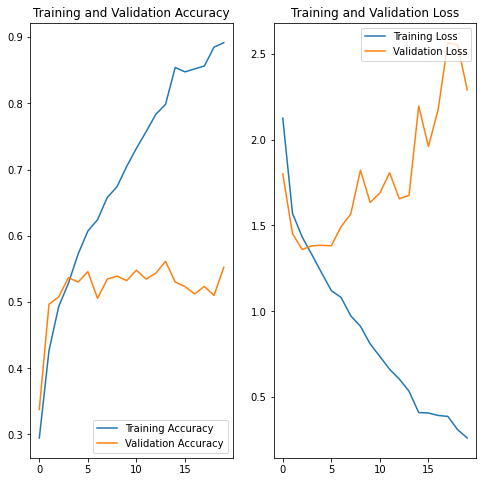

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Overfit or Underfit?


In [19]:
loss_train, accuracy_train = model.evaluate(train_ds, verbose=1)
loss_val, accuracy_val = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", accuracy_train)
print("Validation Accuracy: ",accuracy_val)
print("Training Loss: ",loss_train)
print("Validation Loss", loss_val)

14/14 [==============================] - 0s 19ms/step - loss: 2.2897 - accuracy: 0.5526
Training Accuracy:  0.93359375
Validation Accuracy:  0.5525727272033691
Training Loss:  0.1744823306798935
Validation Loss 2.2896687984466553


Insights: From the above experimentation with model training, it is evident that the model clearly overfits, and thus we need to chose right data augumentation strategy.

In [20]:
#Resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(180, 180, input_shape = (img_height,img_width,3)),
  layers.Rescaling(1./255)
])

## Data Augmentation layer

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

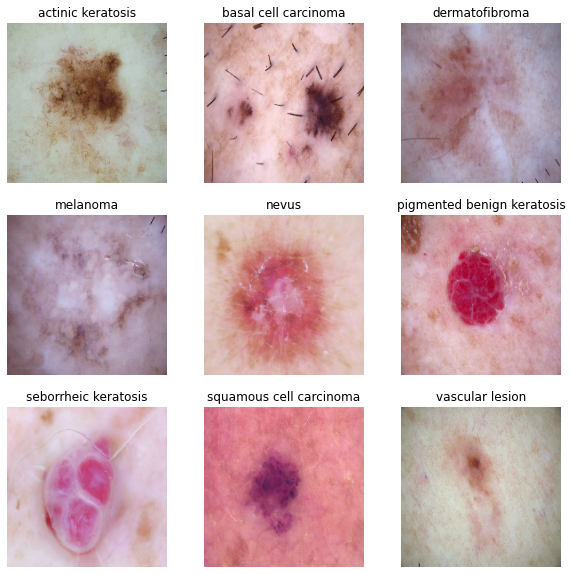

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
#Visualize image 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #print(labels[i])
    plt.title(class_names[i])
    plt.axis("off")

Insight: We can clearly see that the images are flipped and rotated.


### Todo:
### Create the model, compile and train the model


# Model M2

In [23]:
## https://www.tensorflow.org/tutorials/images/data_augmentation
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip

model = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(64,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(128,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Flatten(),
    
    layers.Dense(512,activation='relu'),
    layers.Dense(num_class,activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

### Compiling the model

In [24]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [25]:
# train your model for 20 epochs
epochs = 20
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 75ms/step - loss: 2.1981 - accuracy: 0.2494 - val_loss: 1.9519 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 4s 72ms/step - loss: 1.6805 - accuracy: 0.3862 - val_loss: 1.5819 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 4s 71ms/step - loss: 1.5479 - accuracy: 0.4654 - val_loss: 1.5319 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 4s 71ms/step - loss: 1.4736 - accuracy: 0.4916 - val_loss: 1.4379 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 4s 71ms/step - loss: 1.3869 - accuracy: 0.5078 - val_loss: 1.4628 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 4s 71ms/step - loss: 1.3653 - accuracy: 0.5084 - val_loss: 1.4076 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 4s 71ms/step - loss: 1.3387 - accuracy: 0.5218 - val_loss: 1.4193 - val_accuracy: 0.5034
Epoch 8/20
56

### Visualizing the results

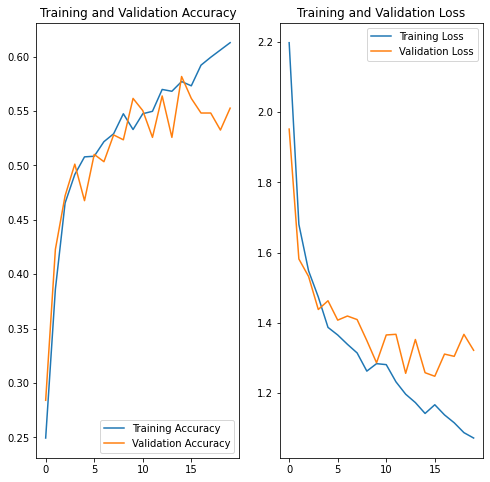

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### **Insight**
- Model M2 has definitely reduce the overfitting and has improved using the data augmentation strategy. However, it still underfits as the accuracy is on the lower side.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,squamous cell carcinoma,181
1,nevus,357
2,basal cell carcinoma,376
3,melanoma,438
4,vascular lesion,139
5,actinic keratosis,114
6,dermatofibroma,95
7,seborrheic keratosis,77
8,pigmented benign keratosis,462


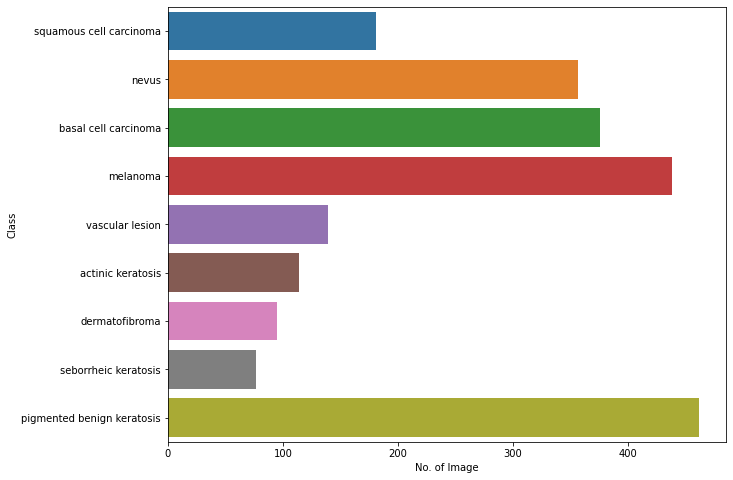

In [28]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
## Seborrheic keratosis, dermatofibroma and Actinic Keratosos
#### - Which classes dominate the data in terms proportionate number of samples?
## Pigmented Benign keratosis & melanoma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


# Augmentor Library layer code

In [30]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
output_dataset="/output/kaggle/working/"
import Augmentor
for i in class_names:
    p=Augmentor.Pipeline(source_directory=path_to_training_dataset+i,output_directory=output_dataset+i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.4)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /output/kaggle/working/actinic keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA1C9261E50>: 100%|██████████| 500/500 [00:20<00:00, 24.87 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /output/kaggle/working/basal cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA246ACC160>: 100%|██████████| 500/500 [00:23<00:00, 21.58 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /output/kaggle/working/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA246B6BB20>: 100%|██████████| 500/500 [00:18<00:00, 27.26 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /output/kaggle/working/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA246ADA880>: 100%|██████████| 500/500 [01:35<00:00,  5.21 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /output/kaggle/working/nevus.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA246A7D310>: 100%|██████████| 500/500 [01:21<00:00,  6.13 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /output/kaggle/working/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA1C91C7F40>: 100%|██████████| 500/500 [00:17<00:00, 28.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /output/kaggle/working/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA246A369A0>: 100%|██████████| 500/500 [00:40<00:00, 12.28 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /output/kaggle/working/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA246B56640>: 100%|██████████| 500/500 [00:16<00:00, 30.41 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /output/kaggle/working/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA246A52910>: 100%|██████████| 500/500 [00:17<00:00, 28.76 Samples/s]


Augmentor has stored the augmented images in the output directory under each skin cancer types.. Lets take a look at total count of augmented images.

### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
image_count_train=0
for i in class_names:
    data_dir_output = pathlib.Path(output_dataset+i)
    new_list=list(data_dir_output.glob('*.jpg'))
    image_count_train+=len(new_list)
    for x in range(len(new_list)):
                   print(new_list[x])

/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0026171.jpg_0aa4e71c-4da0-4064-aa6e-468975ced3db.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0032199.jpg_979803fb-7800-4565-9049-e8b5ea7dc8b7.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0028393.jpg_40241fec-2b94-4821-8a5f-ca715fc5097c.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0031228.jpg_ddebd469-5228-4f21-b409-83de3bc67f6a.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0027562.jpg_65cc12d2-5268-4814-97d2-2e0509dda7e2.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0029840.jpg_03b11104-6792-474a-8f9e-8248c5d30f1f.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0026905.jpg_00296f93-b5da-4c1f-8c1d-221a586b6aec.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0026702.jpg_7910af4d-000f-4a9c-ae56-9e181d1da

In [32]:
print("Total images: " + str(image_count_train))

Total images: 4500


In [33]:
#lets see the lesion list
for i in class_names:
    data_dir_output = pathlib.Path(output_dataset+i)
    new_list=list(data_dir_output.glob('*.jpg'))
    print(i + ": " + str(len(new_list)))

actinic keratosis: 500
basal cell carcinoma: 500
dermatofibroma: 500
melanoma: 500
nevus: 500
pigmented benign keratosis: 500
seborrheic keratosis: 500
squamous cell carcinoma: 500
vascular lesion: 500


#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
train_ds_input = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size,
label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [36]:
train_ds_augmented = tf.keras.preprocessing.image_dataset_from_directory(
  output_dataset,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size,
label_mode='categorical')

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [37]:
#merging the 2 data sets - one from input train dataset and the other from storage having augmented images.
train_ds=train_ds_input.concatenate(train_ds_augmented)

#### **Todo:** Create a validation dataset

In [38]:
val_ds_input = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size,
label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [39]:
val_ds_augmented = tf.keras.preprocessing.image_dataset_from_directory(
  output_dataset,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size,
label_mode='categorical')

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [40]:
#merging the 2 data sets - one from input validation dataset and the other from storage having augmented images.
val_ds=val_ds_input.concatenate(val_ds_augmented)

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

# Model M3

In [42]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
epochs = 30
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 39s 69ms/step - loss: 1.9039 - accuracy: 0.2813 - val_loss: 1.5963 - val_accuracy: 0.4298
Epoch 2/30
169/169 [==============================] - 7s 40ms/step - loss: 1.5879 - accuracy: 0.3869 - val_loss: 1.5323 - val_accuracy: 0.4143
Epoch 3/30
169/169 [==============================] - 7s 40ms/step - loss: 1.4288 - accuracy: 0.4547 - val_loss: 1.4280 - val_accuracy: 0.4417
Epoch 4/30
169/169 [==============================] - 7s 40ms/step - loss: 1.3732 - accuracy: 0.4790 - val_loss: 1.2820 - val_accuracy: 0.5085
Epoch 5/30
169/169 [==============================] - 7s 42ms/step - loss: 1.2948 - accuracy: 0.5126 - val_loss: 1.4401 - val_accuracy: 0.4729
Epoch 6/30
169/169 [==============================] - 7s 42ms/step - loss: 1.2628 - accuracy: 0.5245 - val_loss: 1.7552 - val_accuracy: 0.4417
Epoch 7/30
169/169 [==============================] - 7s 40ms/step - loss: 1.2673 - accuracy: 0.5132 - val_loss: 1.2233 - val_accuracy: 0.528

#### **Todo:**  Visualize the model results

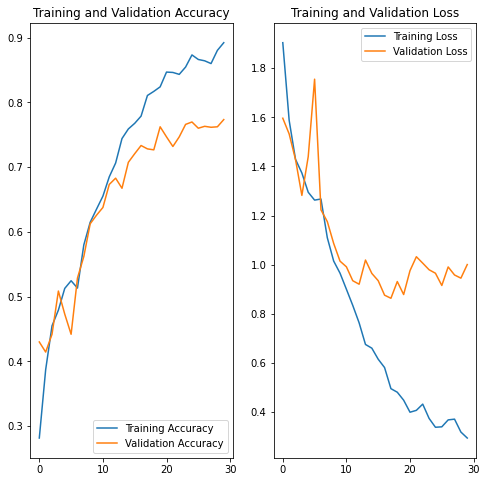

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 54ms/step
Actual Class basal cell carcinoma
Predictive Class pigmented benign keratosis


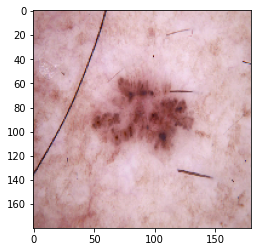

In [49]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Insight:
- The class rebalance helped in reducing the underfitting of the data and the loss is also low. 
- The accuracy helped us predict the test data set images appropriately to certain extent.